原文代码作者：https://github.com/wzyonggege/statistical-learning-method

中文注释制作：机器学习初学者(微信公众号：ID:ai-start-com)

配置环境：python 3.6

代码全部测试通过。
![gongzhong](../gongzhong.jpg)

#  第3章 k近邻法

#### 距离度量

In [1]:
import math
from itertools import combinations

- p = 1 曼哈顿距离
- p = 2 欧氏距离
- p = inf  闵式距离minkowski_distance 

In [2]:
def L(x, y, p=2):
    # x1 = [1, 1], x2 = [5,1]
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1/p)
    else:
        return 0

In [3]:
# 课本例3.1
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]

In [4]:
# x1, x2
for i in range(1, 5):
    r = { '1-{}'.format(c):L(x1, c, p=i) for c in [x2, x3]}
    print(min(zip(r.values(), r.keys())))

(4.0, '1-[5, 1]')
(4.0, '1-[5, 1]')
(3.7797631496846193, '1-[4, 4]')
(3.5676213450081633, '1-[4, 4]')


python实现，遍历所有数据点，找出n个距离最近的点的分类情况，少数服从多数

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter

In [6]:
# data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
# data = np.array(df.iloc[:100, [0, 1, -1]])

In [7]:
df

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


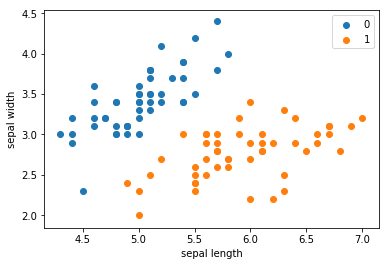

In [8]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [9]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X):
        # 取出n个点
        knn_list = []
        for i in range(self.n):
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))
            
        for i in range(self.n, len(self.X_train)):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
                
        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
        max_count = sorted(count_pairs, key=lambda x:x)[-1]
        return max_count
    
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [11]:
clf = KNN(X_train, y_train)

In [12]:
clf.score(X_test, y_test)

1.0

In [13]:
test_point = [6.0, 3.0]
print('Test Point: {}'.format(clf.predict(test_point)))

Test Point: 1.0


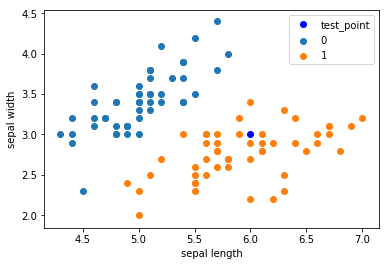

In [14]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

# 我在网上找了kd树的介绍，不妨先看看（廖睿力20181230）

https://zhuanlan.zhihu.com/p/23966698


# 接下来的是上一篇文章的后续，我摘录出来 ，下面是原网址
https://www.joinquant.com/post/3227?f=study&m=math

## 【量化课堂】scikit-learn 之 kNN 分类

### 功能详解
本篇中，我们讲解的是 scikit-learn 库中的 neighbors.KNeighborsClassifier，翻译为 k 最近邻分类功能，也就是我们常说的 kNN，k-nearest neighbors。首先进行这个类初始化：

In [15]:
from sklearn import neighbors

neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n-jobs=1)

n_neighbors 就是 kNN 里的 k，就是在做分类时，我们选取问题点最近的多少个最近邻。

weights 是在进行分类判断时给最近邻附上的加权，默认的 'uniform' 是等权加权，还有 'distance' 选项是按照距离的倒数进行加权，也可以使用用户自己设置的其他加权方法。举个例子：假如距离询问点最近的三个数据点中，有 1 个 A 类和 2 个 B 类，并且假设 A 类离询问点非常近，而两个 B 类距离则稍远。在等权加权中，3NN 会判断问题点为 B 类；而如果使用距离加权，那么 A 类有更高的权重（因为更近），如果它的权重高于两个 B 类的权重的总和，那么算法会判断问题点为 A 类。权重功能的选项应该视应用的场景而定。

algorithm 是分类时采取的算法，有 'brute'、'kd_tree' 和 'ball_tree'。kd_tree 的算法在 kd 树文章中有详细介绍，而 ball_tree 是另一种基于树状结构的 kNN 算法，brute 则是最直接的蛮力计算。根据样本量的大小和特征的维度数量，不同的算法有各自的优势。默认的 'auto' 选项会在学习时自动选择最合适的算法，所以一般来讲选择 auto 就可以。

leaf_size 是 kd_tree 或 ball_tree 生成的树的树叶（树叶就是二叉树中没有分枝的节点）的大小。在 kd 树文章中我们所有的二叉树的叶子中都只有一个数据点，但实际上树叶中可以有多于一个的数据点，算法在达到叶子时在其中执行蛮力计算即可。对于很多使用场景来说，叶子的大小并不是很重要，我们设 leaf_size=1 就好。
metric 和 p，是我们在 kNN 入门文章中介绍过的距离函数的选项，如果 metric ='minkowski' 并且 p=p 的话，计算两点之间的距离就是
$$d(x,y)=(\sum_{i=1}^n{|x_i-y_i|}^p)1/p$$


一般来讲，默认的 metric='minkowski'（默认）和 p=2（默认）就可以满足大部分需求。其他的 metric 选项可见说明文档。metric_params 是一些特殊 metric 选项需要的特定参数，默认是 None。
n_jobs 是并行计算的线程数量，默认是 1，输入 -1 则设为 CPU 的内核数。

在创建了一个 KNeighborsClassifier 类之后，我们需要给它数据来进行学习。这时需要使用 fit() 拟合功能。

neighbors.KNeighborsClassifier.fit(X,y)


在这里：

X 是一个 list 或 array 的数据，每一组数据可以是 tuple 也可以是 list 或者一维 array，但要注意所有数据的长度必须一样（等同于特征的数量）。当然，也可以把 X 理解为一个矩阵，其中每一横行是一个样本的特征数据。

y 是一个和 X 长度相同的 list 或 array，其中每个元素是 X 中相对应的数据的分类标签。

KNeighborsClassifier 类在对训练数据执行 fit() 后会根据原先 algorithm 的选项，依据训练数据生成一个 kd_tree 或者 ball_tree。如果输入是 algorithm='brute'，则什么都不做。这些信息都会被保存在一个类中，我们可以用它进行预测和计算。几个常用的功能有：



### k 最近邻

neighbors.KNeighborsClassifier.kneighbors(X=None, n_neighbors=None, return_distance= True)

这里 X 是一 list 或 array 的坐标，如果不提供，则默认输入训练时的样本数据。

n_neighbors 是指定搜寻最近的样本数据的数量，如果不提供，则以初始化 kNeighborsClassifier 时的 n_neighbors 为准。

这个功能输出的结果是 (dist=array[array[float]], index=array[array[int]])。index 的长度和 X 相同，index[i] 是长度为 n_neighbors 的一 array 的整数；假设训练数据是 fit(X_train, y_train)，那么 X_train(index[i][j]) 是在训练数据（X_train）中离 X[i] 第 j 近的元素，并且 dist[i][j] 是它们之间的距离。

输入的 return_distance 是是否输出距离，如果选择 False，那么功能的输出会只有 index 而没有 dist。

### 预测

neighbors.kNeighborsClassifier.predict(X)

也许是最常用的预测功能。输入 X 是一 list 或 array 的坐标，输出y是一个长度相同的 array，y[i] 是通过 kNN 分类对 X[i] 所预测的分类标签。

### 概率预测

neighbors.kNeighborsClassifier.predict_proba(X)

### 正确率打分

neighbors.KNeighborsClassifier.score(X, y, sample_weight=None)

这是用来评估一次 kNN 学习的准确率的方法。很多可能会因为样本特征的选择不当或者 k 值得选择不当而出现过拟合或者偏差过大的问题。为了保证训练方法的准确性，一般我们会将已经带有分类标签的样本数据分成两组，一组进行学习，一组进行测试。这个 score() 就是在学习之后进行测试的功能。同 fit() 一样，这里的 X 是特征坐标，y 是样本的分类标签；sample_weight 是对样本的加权，长度等于 sample 的数量。返回的是正确率的百分比。

## 实际例子

除了sklearn.neighbors，还需要导入numpy和matplotlib画图。# 

In [16]:
import random
from sklearn import neighbors
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

我们随机生成 6 组 200 个的正态分布


In [17]:
x1 = np.random.normal(50, 6, 200)
y1 = np.random.normal(5, 0.5, 200)

x2 = np.random.normal(30,6,200)
y2 = np.random.normal(4,0.5,200)

x3 = np.random.normal(45,6,200)
y3 = np.random.normal(2.5, 0.5, 200)

x1、x2、x3 作为 x 坐标，y1、y2、y3 作为 y 坐标，两两配对。(x1,y1) 标为 1 类，(x2, y2) 标为 2 类，(x3, y3)是 3 类。将它们画出得到下图，1 类是蓝色，2 类红色，3 类绿色。

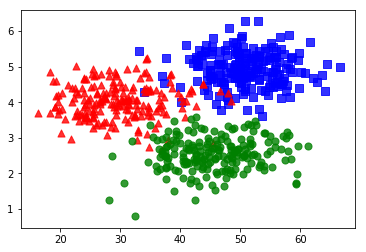

In [18]:
plt.scatter(x1,y1,c='b',marker='s',s=50,alpha=0.8)
plt.scatter(x2,y2,c='r', marker='^', s=50, alpha=0.8)
plt.scatter(x3,y3, c='g', s=50, alpha=0.8)

我们把所有的 x 坐标和 y 坐标放在一起

In [19]:
x_val = np.concatenate((x1,x2,x3))
y_val = np.concatenate((y1,y2,y3))

记得计算距离的归一化问题吗？我们求出 x 值的最大差还有 y 值的最大差。

In [20]:
x_diff = max(x_val)-min(x_val)
y_diff = max(y_val)-min(y_val)

将坐标除以这个差以归一化，再将 x 和 y 值两两配对。

In [21]:
x_normalized = [x/(x_diff) for x in x_val]
y_normalized = [y/(y_diff) for y in y_val]
xy_normalized = zip(x_normalized,y_normalized)

训练使用的特征数据已经准备好了，还需要生成相应的分类标签。生成一个长度600的list，前200个是1，中间200个是2，最后200个是3，对应三种标签。

In [22]:
labels = [1]*200+[2]*200+[3]*200

然后，就要生成 sklearn 的最近 k 邻分类功能了。参数中，n_neighbors 设为 30，其他的都使用默认值即可。

In [23]:
clf = neighbors.KNeighborsClassifier(30)

（注意我们是从sklearn里导入了neighbors。如果是直接导入了sklearn，应该输入sklearn.neighbors.KNeighborsClassifier()）

下面就要进行拟合了。归一化的数据是 xy_normalized，分类标签是 labels，

In [24]:
clf.fit(list(xy_normalized), list(labels))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

就这么简单。下面我们来实现一些功能。

### k 最近邻

首先，我们想知道 (50,5) 和 (30,3) 两个点附近最近的 10 个样本分别都是什么。啊，坐标别忘了除以 x_diff 和 y_diff 来归一化。

In [25]:
nearests = clf.kneighbors([(50/x_diff, 5/y_diff),(30/x_diff, 3/y_diff)], 10, False)
nearests

array([[136,  46,  60,  61,  17, 196,  16,  58, 158, 138],
       [566, 203, 310, 210, 229, 268, 217, 377, 349, 291]])

注意这里返回的是训练数据中样本的下标

### 预测

还是上面那两个点，我们通过 30NN 来判断它们属于什么类别。

In [26]:
prediction = clf.predict([(50/x_diff, 5/y_diff),(30/x_diff, 3/y_diff)])
prediction

array([1, 2])

也就是说 (50,5) 判断为 1 类，而 (30,3) 是 2 类。


### 概率预测

In [27]:
prediction_proba = clf.predict_proba([(50/x_diff, 5/y_diff),(30/x_diff, 3/y_diff)])
prediction_proba

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.83333333,  0.16666667]])

 ### 准确率打分

我们再用同样的均值和标准差生成一些正态分布点，以此检测预测的准确性。

In [28]:
x1_test = np.random.normal(50, 6, 200)
y1_test = np.random.normal(5, 0.5, 200)

x2_test = np.random.normal(30,6,200)
y2_test = np.random.normal(4,0.5,200)

x3_test = np.random.normal(45,6,200)
y3_test = np.random.normal(2.5, 0.5, 200)

xy_test_normalized = [[i,j] for i,j in zip(np.concatenate((x1_test,x2_test,x3_test))/x_diff, \
                        np.concatenate((y1_test,y2_test,y3_test))/y_diff)]

labels_test = [1]*200+[2]*200+[3]*200


测试数据生成完毕，下面进行测试

In [29]:
score = clf.score(list(xy_test_normalized), list(labels_test))
score

0.97833333333333339

得到预测的正确率是 97% 还是很不错的。

再看一下，如果使用 2NN 分类，那么准确率的平分就变为…

In [30]:
clf1 = neighbors.KNeighborsClassifier(2)
xy_normalized = [[x,y] for x,y in zip(x_normalized,y_normalized)]
clf1.fit(np.array(xy_normalized),
         np.array(labels))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [31]:
clf1.score(np.array(xy_test_normalized), \
           np.array(labels_test))

0.93500000000000005

### 生成些漂亮的图

说到 kNN 那当然离不开分类图，不过这一般是为了教学用的，毕竟只能展示两个维度的数据，超过三个特征的话就画不出来了。所以这部分内容只是本篇的附加部分，有兴趣的读者可以向下阅读。

首先我们需要生成一个区域里大量的坐标点。这要用到 np.meshgrid() 函数。给定两个 array，比如 x=[1,2,3] 和 y=[4,5]，np.meshgrid(x,y) 会输出两个矩阵，这两个叠加到一起得到六个坐标，就是以 [1,2,3] 为横轴，[4,5] 为竖轴所得到的长方形区间内的所有坐标点。

好，我们现在要生成 [1,80]x[1,7] 的区间里的坐标点，横轴要每 0.1 一跳，竖轴每 0.01 一跳。于是


In [32]:
xx,yy = np.meshgrid(np.arange(1,70.1,0.1), np.arange(1,7.01,0.01))

于是 xx 和 yy 都是 601 乘 691 的矩阵。还有，不要忘了除以 x_diff 和 y_diff 来将坐标归一化。



In [33]:
xx_normalized = xx/x_diff
yy_normalized = yy/y_diff

下面，np.ndarray.ravel() 功能可以把一个矩阵抻直成一个一维 array，np.c_() 又把两个 array 粘起来（类似于 zip）

In [34]:
coords = np.c_[xx_normalized.ravel(), yy_normalized.ravel()]

得到一个 array 的坐标。下面就可以进行预测

In [35]:
Z = clf.predict(coords)

当然，Z 是一个一维 array，为了和 xx 还有 yy 相对应，要把Z的形状再转换回矩阵

In [36]:
Z = Z.reshape(xx.shape)

下面用 pcolormesh 画出背景颜色。这里，ListedColormap 是自己生成 colormap 的功能，#rrggbb 颜色的 rgb 代码。pcolormesh 会根据 Z 的值（1、2、3）选择 colormap 里相对应的颜色。pcolormesh 和 ListedColormap 的具体使用方法会在未来关于画图的文章中细讲。

(10, 70, 1, 7)

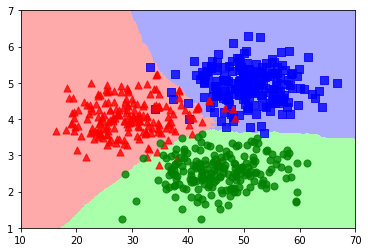

In [37]:
light_rgb = ListedColormap([ '#AAAAFF', '#FFAAAA','#AAFFAA'])
plt.pcolormesh(xx, yy,Z, cmap=light_rgb)
plt.scatter(x1,y1,c='b',marker='s',s=50,alpha=0.8)
plt.scatter(x2,y2,c='r', marker='^', s=50, alpha=0.8)
plt.scatter(x3,y3, c='g', s=50, alpha=0.8)
plt.axis((10, 70,1,7))

下面再进行概率预测，使用

In [38]:
Z_proba = clf.predict_proba(coords)

得到每个坐标点的分类概率值。假设我们想画出红色的概率，那么提取所有坐标的 2 类概率，转换成矩阵形状

In [39]:
Z_proba_reds = Z_proba[:,1].reshape(xx.shape)

(10, 70, 1, 7)

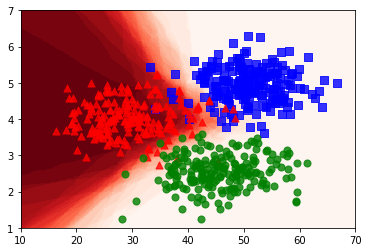

In [40]:
plt.pcolormesh(xx, yy,Z_proba_reds, cmap='Reds')
plt.scatter(x1,y1,c='b',marker='s',s=50,alpha=0.8)
plt.scatter(x2,y2,c='r', marker='^', s=50, alpha=0.8)
plt.scatter(x3,y3, c='g', s=50, alpha=0.8)
plt.axis((10, 70,1,7))

# 以下为机器之心整理的 scikitlearn

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
clf_sk.score(X_test, y_test)

1.0

### sklearn.neighbors.KNeighborsClassifier

- n_neighbors: 临近点个数
- p: 距离度量
- algorithm: 近邻算法，可选{'auto', 'ball_tree', 'kd_tree', 'brute'}
- weights: 确定近邻的权重

### kd树

In [44]:
# kd-tree每个结点中主要包含的数据结构如下 
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split      # 整数（进行分割维度的序号）
        self.left = left        # 该结点分割超平面左子空间构成的kd-tree
        self.right = right      # 该结点分割超平面右子空间构成的kd-tree
 
 
class KdTree(object):
    def __init__(self, data):
        k = len(data[0])  # 数据维度
        
        def CreateNode(split, data_set): # 按第split维划分数据集exset创建KdNode
            if not data_set:    # 数据集为空
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为需要获取的数据在对象中的序号
            #data_set.sort(key=itemgetter(split)) # 按要进行分割的那一维数据排序
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2      # //为Python中的整数除法
            median = data_set[split_pos]        # 中位数分割点             
            split_next = (split + 1) % k        # cycle coordinates
            
            # 递归的创建kd树
            return KdNode(median, split, 
                          CreateNode(split_next, data_set[:split_pos]),     # 创建左子树
                          CreateNode(split_next, data_set[split_pos + 1:])) # 创建右子树
                                
        self.root = CreateNode(0, data)         # 从第0维分量开始构建kd树,返回根节点


# KDTree的前序遍历
def preorder(root):  
    print (root.dom_elt)  
    if root.left:      # 节点不为空
        preorder(root.left)  
    if root.right:  
        preorder(root.right)      

In [45]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple", "nearest_point  nearest_dist  nodes_visited")
  
def find_nearest(tree, point):
    k = len(point) # 数据维度
    def travel(kd_node, target, max_dist):
        if kd_node is None:     
            return result([0] * k, float("inf"), 0) # python中用float("inf")和float("-inf")表示正负无穷
 
        nodes_visited = 1
        
        s = kd_node.split        # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”
        
        if target[s] <= pivot[s]:           # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node  = kd_node.left     # 下一个访问节点为左子树根节点
            further_node = kd_node.right    # 同时记录下右子树
        else:                               # 目标离右子树更近
            nearer_node  = kd_node.right    # 下一个访问节点为右子树根节点
            further_node = kd_node.left
 
        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域
        
        nearest = temp1.nearest_point       # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist           # 更新最近距离
        
        nodes_visited += temp1.nodes_visited  
 
        if dist < max_dist:     
            max_dist = dist    # 最近点将在以目标点为球心，max_dist为半径的超球体内
            
        temp_dist = abs(pivot[s] - target[s])    # 第s维上目标点与分割超平面的距离
        if  max_dist < temp_dist:                # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited) # 不相交则可以直接返回，不用继续判断
            
        #----------------------------------------------------------------------  
        # 计算目标点与分割点的欧氏距离  
        temp_dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(pivot, target)))     
        
        if temp_dist < dist:         # 如果“更近”
            nearest = pivot          # 更新最近点
            dist = temp_dist         # 更新最近距离
            max_dist = dist          # 更新超球体半径
        
        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist) 
        
        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:        # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point    # 更新最近点
            dist = temp2.nearest_dist        # 更新最近距离
 
        return result(nearest, dist, nodes_visited)
 
    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

### 例3.2

In [46]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [47]:
from time import clock
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]     

In [48]:
ret = find_nearest(kd, [3,4.5])
print (ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [49]:
N = 400000
t0 = clock()
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
t1 = clock()
print ("time: ",t1-t0, "s")
print (ret2)

time:  6.559554000000002 s
Result_tuple(nearest_point=[0.09066235237018083, 0.49961976520204043, 0.8005681562237059], nearest_dist=0.009362640826966646, nodes_visited=99)
